# Determining the Age Using CV Deep Learning Model

Supermarket chain Bread&Salt introduces a computer vision system for processing customers' photos. Photo fixation at checkout area will help to determine the age of customers in order to:

- Analyze purchases and offer products that may be of interest to buyers of this age group;
- Control the conscientiousness of cashiers when selling alcohol;
- Security reasons.

The purpose of this work is to develop ML-model that will determine the approximate age of a person with a MAE value of 8 and below from a photograph. We already have a set of photographs of people with age labels.

The work will be carried out in the following order:

- Exploratory analysis. Consider the size and quality of the dataset.
- Preparing Data for Model Training
- Preparing and training the model
- Analysis of model training results

## Exploratory Data Analysis

In [1]:
# Importing required libraries
import re
import warnings
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set(palette='Set2', font_scale=1.25)
warnings.filterwarnings('ignore')

In [2]:
# Loading data with labels
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

There are 7591 rows with marked age value in total. There is not a lot of data, so we will use augmentation while fine tuning the neural network.

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


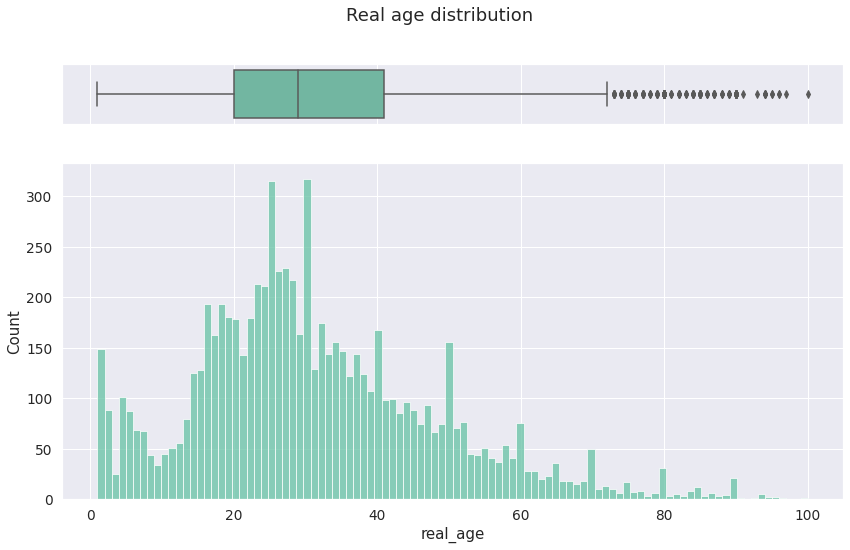

In [22]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(14, 8))

sns.boxplot(labels['real_age'], ax=ax_box)
sns.histplot(data=labels, x='real_age', ax=ax_hist, bins=100)
ax_box.set(xlabel='')

fig.suptitle('Real age distribution')
plt.show()

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

The age values are in the range from 1 to 100 years. Mean age 31.2 years. Median is 29 years. The distribution looks quite natural. The surge at the beginning of the graph can be explained by the fact that children at the first years of life are likely photographed more often. We can also notice spikes in the round age values. This fact can be explained by the fact that some of the photographs were collected on the Internet and the age was indicated roughly, or for old photographs it was indicated approximately.

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=23)

Found 7591 validated image filenames.


In [9]:
# Let's explore the first batch
features, target = next(datagen_flow)

Displaying 15 images for visual reference

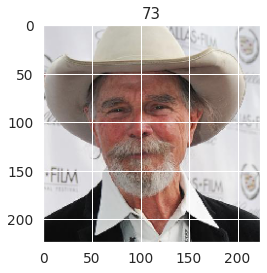

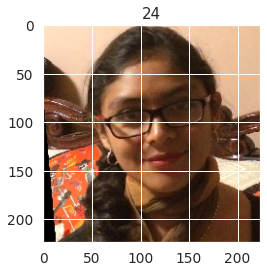

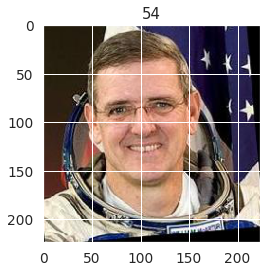

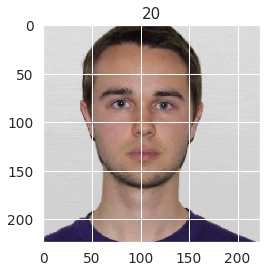

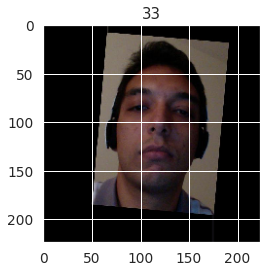

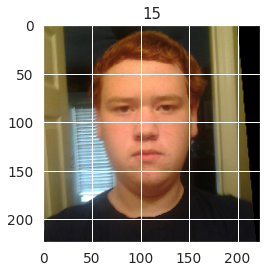

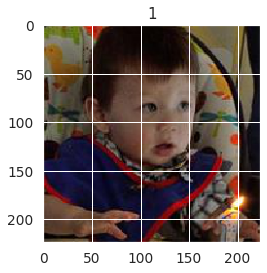

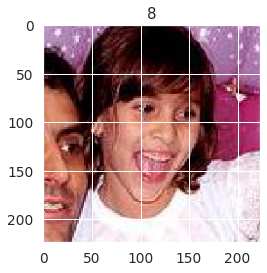

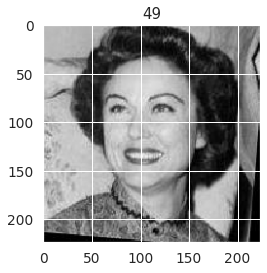

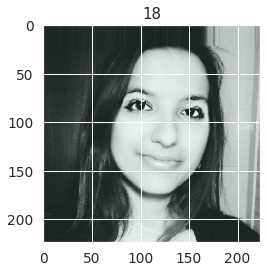

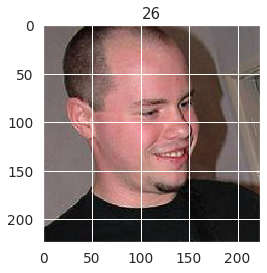

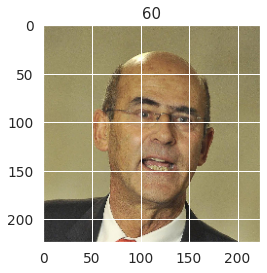

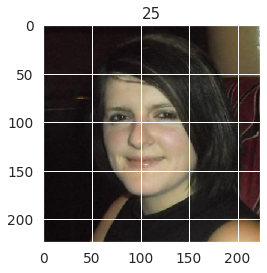

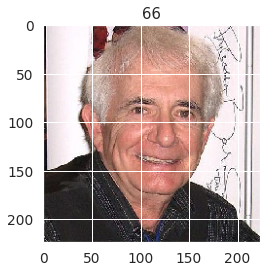

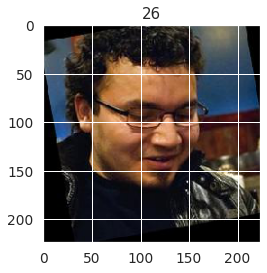

In [10]:
for age, photo in zip(target[:15], features[:15]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

Photos from the dataset of different quality, taken in different lighting conditions. There are both color and black and white images. The following features were also found in some of the images:

- photos are tilted
- incorrect white balance
- incorrect exposure
- There are objects obscuring part of the face, hats, glasses, shadow, etc on photos.
- different angles, different facial expressions, etc. 

We can assume that since the photos are presented in such different ways, the model will be less sensitive to the quality of the pictures.

#### Summary

The dataset contains 7591 photographs of people labeled by real age. Age values are in range from 1 to 100 years with a mean of 31.2 years and a median of 29 years. Photos from the dataset of different quality, taken in different lighting conditions. There are both color and black and white images. We can assume that since the photos are presented in such different ways, the model will be less sensitive to the quality of the pictures.

## Model Training

(The code in this section runs in a separate GPU Server, so it's formatted not as a cell with code, but as code in a text cell)

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def load_train(path):
    '''
    Function for loading the training sample. It takes as an argument the path to the directory with files,
    returns an instance of the DataGenerator iterator.
    '''
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(
        rescale= 1./255, 
        validation_split=0.20)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        seed=23)
    
    return train_datagen_flow


def load_test(path):
    '''
    Function to load the validation set. It takes as an argument the path to the directory with files,
    returns an instance of the DataGenerator iterator.
    '''
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.20)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=23)
    
    return test_datagen_flow


def create_model(input_shape):
    '''
    The function takes on the size of the input tensor, returns a trained model based on ResNet102
    with the last two layers removed and the AveragePooling layers and a fully connected layer with one output added
    and a leaky ReLU activation.
    '''
    backbone = ResNet101(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
    leaky = LeakyReLU(alpha=0.05)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation=leaky))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',metrics=['mae']) 
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    '''
    A function to train the model. Takes as input a trainable model, training and validation data,
    returns the trained model.
    When learning, the function adds the ability to stop early stop, and also
    decrease in the learning rate when reaching a plateau in the metric on the validation set.
    '''
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    early_stopping = EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True)

    learning_rate_reduction = ReduceLROnPlateau(patience=2,
                                            verbose=1,
                                            factor=0.2,
                                            cooldown=1,
                                            min_lr=0.0001)
    callbacks= [early_stopping, learning_rate_reduction]
    
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=callbacks,
              verbose=2)
    
    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/20
2023-03-15 13:36:09.805400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-15 13:36:10.205210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 113s - loss: 216.9598 - mae: 10.5024 - val_loss: 1088.7079 - val_mae: 28.4796
Epoch 2/20
190/190 - 75s - loss: 61.5359 - mae: 6.0124 - val_loss: 429.1208 - val_mae: 15.5950
Epoch 3/20
190/190 - 87s - loss: 30.6411 - mae: 4.2881 - val_loss: 193.0708 - val_mae: 10.3755
Epoch 4/20
190/190 - 102s - loss: 19.8822 - mae: 3.4313 - val_loss: 100.3918 - val_mae: 7.6053
Epoch 5/20
190/190 - 92s - loss: 15.2061 - mae: 3.0393 - val_loss: 81.5369 - val_mae: 6.7802
Epoch 6/20
190/190 - 73s - loss: 11.3597 - mae: 2.6018 - val_loss: 69.9880 - val_mae: 6.4990
Epoch 7/20
190/190 - 72s - loss: 11.3524 - mae: 2.5812 - val_loss: 68.7698 - val_mae: 6.4286
Epoch 8/20
190/190 - 72s - loss: 8.6953 - mae: 2.2365 - val_loss: 66.5665 - val_mae: 6.2540
Epoch 9/20
190/190 - 54s - loss: 7.0683 - mae: 1.9941 - val_loss: 64.5033 - val_mae: 6.1425
Epoch 10/20
190/190 - 44s - loss: 5.9045 - mae: 1.8197 - val_loss: 68.8468 - val_mae: 6.2809
Epoch 11/20
190/190 - 45s - loss: 5.5455 - mae: 1.7713 - val_loss: 61.3120 - val_mae: 5.9865
Epoch 12/20
190/190 - 62s - loss: 5.0622 - mae: 1.6868 - val_loss: 66.2305 - val_mae: 6.2680
Epoch 13/20
190/190 - 82s - loss: 5.0505 - mae: 1.7154 - val_loss: 63.7158 - val_mae: 6.0146
Epoch 14/20
Epoch 15/20
190/190 - 67s - loss: 5.4019 - mae: 1.7429 - val_loss: 63.1508 - val_mae: 6.0670
190/190 - 78s - loss: 5.6505 - mae: 1.7841 - val_loss: 60.4717 - val_mae: 5.7996
Epoch 16/20
190/190 - 52s - loss: 5.6817 - mae: 1.8023 - val_loss: 65.3584 - val_mae: 6.1852
Epoch 17/20
190/190 - 47s - loss: 6.1775 - mae: 1.8885 - val_loss: 71.1149 - val_mae: 6.2769
Epoch 18/20
190/190 - 45s - loss: 5.8934 - mae: 1.8282 - val_loss: 77.3490 - val_mae: 6.5205
Epoch 19/20
190/190 - 76s - loss: 6.0004 - mae: 1.8441 - val_loss: 60.2054 - val_mae: 5.9159
Epoch 20/20
190/190 - 62s - loss: 5.8807 - mae: 1.8198 - val_loss: 61.9708 - val_mae: 5.9135
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 61.9708 - mae: 5.9135
Test MAE: 5.9135

```

#### Conclusion

The training was carried out on a pre-trained ResNet102 model, in which the last two layers were replaced, respectively, with a connected layer with one output neuron and leaky ReLU activation. Training took place on 20 epochs. The final value of the MAE metric on the validation sample was 5.91.

## Analysis of the trained model

As a result of training on a modified version of the ResNet102 pre-trained neural network with the last two layers changed, we obtained the MAE value on the validation set of 5.91, which is below the target value and close to the value obtained by the authors of the article*.

*E. Agustsson, R. Timofte, S. Escalera, X. Baro, I. Guyon and R. Rothe, "Apparent and Real Age Estimation in Still Images with Deep Residual Regressors on Appa-Real Database," 2017 12th IEEE International Conference on Automatic Face & Gesture Recognition (FG 2017), Washington, DC, USA, 2017, pp. 87-94, doi: 10.1109/FG.2017.20.

Plotting the model train graph.

Since the history file is not available for download from the server, we just paste the data from the screen and parse it.

In [11]:
history = '''190/190 - 113s - loss: 216.9598 - mae: 10.5024 - val_loss: 1088.7079 - val_mae: 28.4796
Epoch 2/20
190/190 - 75s - loss: 61.5359 - mae: 6.0124 - val_loss: 429.1208 - val_mae: 15.5950
Epoch 3/20
190/190 - 87s - loss: 30.6411 - mae: 4.2881 - val_loss: 193.0708 - val_mae: 10.3755
Epoch 4/20
190/190 - 102s - loss: 19.8822 - mae: 3.4313 - val_loss: 100.3918 - val_mae: 7.6053
Epoch 5/20
190/190 - 92s - loss: 15.2061 - mae: 3.0393 - val_loss: 81.5369 - val_mae: 6.7802
Epoch 6/20
190/190 - 73s - loss: 11.3597 - mae: 2.6018 - val_loss: 69.9880 - val_mae: 6.4990
Epoch 7/20
190/190 - 72s - loss: 11.3524 - mae: 2.5812 - val_loss: 68.7698 - val_mae: 6.4286
Epoch 8/20
190/190 - 72s - loss: 8.6953 - mae: 2.2365 - val_loss: 66.5665 - val_mae: 6.2540
Epoch 9/20
190/190 - 54s - loss: 7.0683 - mae: 1.9941 - val_loss: 64.5033 - val_mae: 6.1425
Epoch 10/20
190/190 - 44s - loss: 5.9045 - mae: 1.8197 - val_loss: 68.8468 - val_mae: 6.2809
Epoch 11/20
190/190 - 45s - loss: 5.5455 - mae: 1.7713 - val_loss: 61.3120 - val_mae: 5.9865
Epoch 12/20
190/190 - 62s - loss: 5.0622 - mae: 1.6868 - val_loss: 66.2305 - val_mae: 6.2680
Epoch 13/20
190/190 - 82s - loss: 5.0505 - mae: 1.7154 - val_loss: 63.7158 - val_mae: 6.0146
Epoch 14/20
Epoch 15/20
190/190 - 67s - loss: 5.4019 - mae: 1.7429 - val_loss: 63.1508 - val_mae: 6.0670
190/190 - 78s - loss: 5.6505 - mae: 1.7841 - val_loss: 60.4717 - val_mae: 5.7996
Epoch 16/20
190/190 - 52s - loss: 5.6817 - mae: 1.8023 - val_loss: 65.3584 - val_mae: 6.1852
Epoch 17/20
190/190 - 47s - loss: 6.1775 - mae: 1.8885 - val_loss: 71.1149 - val_mae: 6.2769
Epoch 18/20
190/190 - 45s - loss: 5.8934 - mae: 1.8282 - val_loss: 77.3490 - val_mae: 6.5205
Epoch 19/20
190/190 - 76s - loss: 6.0004 - mae: 1.8441 - val_loss: 60.2054 - val_mae: 5.9159
Epoch 20/20
190/190 - 62s - loss: 5.8807 - mae: 1.8198 - val_loss: 61.9708 - val_mae: 5.9135'''

Get the MAE values on the training and validation samples from the training history, then we will create a table from them and build a model training graph based on it.

In [12]:
train_mae = re.findall('\smae: (\d+\.\d+)', history)

In [13]:
valid_mae = re.findall('val_mae: (\d+\.\d+)', history)

In [14]:
train_mae = list(map(float, train_mae))

In [15]:
valid_mae = list(map(float, valid_mae))

In [16]:
epochs = list(range(1, len(train_mae) + 1))

In [17]:
results = pd.DataFrame(data=zip(train_mae, valid_mae, epochs), columns=['train', 'valid', 'epochs'])

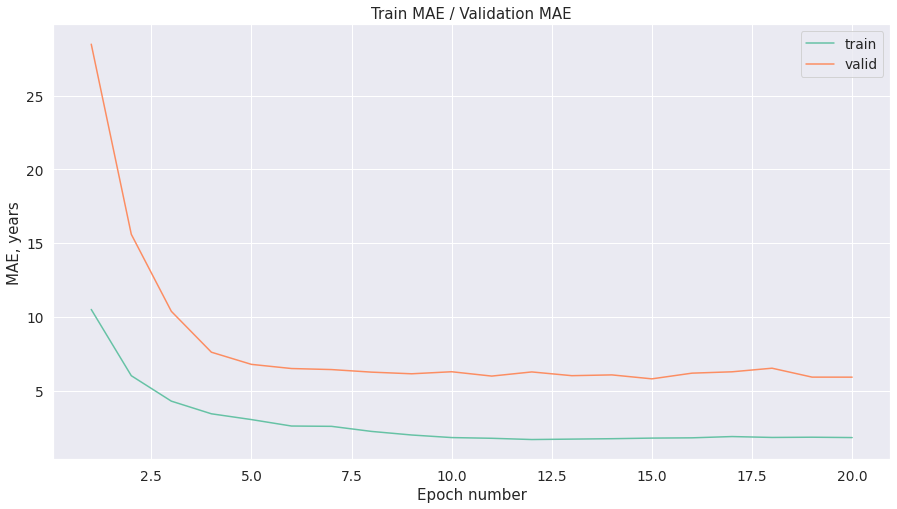

In [18]:
results.plot(x='epochs', 
             y=['train', 'valid'], 
             figsize=(15, 8), 
             title='Train MAE / Validation MAE',
             xlabel='Epoch number',
             ylabel='MAE, years');

According to the training schedule, a sharp improvement in the quality of the model from 1 to 5 epochs is noticeable. After the 12th-13th epoch, there are no significant improvements in the validation set.

#### Conclusion

To obtain the desired result, it would be enough to train the model on 5 epochs. Using more training epochs, we managed to get the MAE metric value lower.

## Summary

During the exploratory data analysis, the following properties was discovered:

The dataset contains 7591 photographs of people labeled by real age.
Age values range from 1 to 100 years with a mean of 31.2 years and a median of 29 years. Photos from the dataset of different quality, taken in different lighting conditions. There are both color and black and white images.
We made the assumption that since the photos are presented in such different ways, the model will be less sensitive to the quality of the pictures.

Next, we prepared and trained the neural network. The training was carried out on a pre-trained ResNet102 model.The last two layers of model were replaced, respectively, with a connected layer with one output neuron and leaky ReLU activation. Training took place on 20 epochs. The final value of the MAE metric on the validation sample was 5.91.

As a result of training on a modified version of the ResNet102 pre-trained neural network with the last two layers changed. We obtained the MAE value on the validation set of 5.91, which is below the target value and close to the value obtained by the authors of the article*.

According to the training schedule, a sharp improvement in the quality of the model from 1 to 5 epochs is noticeable. After the 12th-13th epoch, there are no significant improvements in the validation set.
To obtain the desired result, it would be enough to train the model on 5 epochs. Using more training epochs, we managed to get the MAE metric value lower.

*E. Agustsson, R. Timofte, S. Escalera, X. Baro, I. Guyon and R. Rothe, "Apparent and Real Age Estimation in Still Images with Deep Residual Regressors on Appa-Real Database," 2017 12th IEEE International Conference on Automatic Face & Gesture Recognition (FG 2017), Washington, DC, USA, 2017, pp. 87-94, doi: 10.1109/FG.2017.20.